<a href="https://colab.research.google.com/github/Martinsoyyo/Sellos/blob/master/Full_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Condiciones iniciales

In [24]:
address          = '/content/drive/MyDrive/Colada_40mm_python'
image_size       = 128
train_percentage = 0.75
epochs           = 100
batch_size       = 100
use_gpu          = True

import torch
device = torch.device("cuda" if use_gpu else "cpu")

#Dataset Builder

In [ ]:
## Crea Tensores [_images , _target ]

### Funciones Auxiliares

In [6]:
def GetDirectoryStructure(dirName):
    listOfFile = os.listdir(dirName)
    alldir = list()

    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
       
        if os.path.isdir(fullPath):
            alldir.append(fullPath)
    return alldir

In [7]:
def GetFilesFromDirectory(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()

    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)

        if not os.path.isdir(fullPath):
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import random
#random.shuffle(data_csv)
#data_csv

### Levanta todos los nombres de archivos de imagenes.

In [17]:
import os

data_csv = []

dirs = GetDirectoryStructure(address)
_dir_count = 0
for _dir in dirs:
  files = GetFilesFromDirectory(_dir)
  for _files in files:
    fullPath = os.path.join(_dir, _files)
    data_csv.append( [fullPath , _dir_count-1] );
  _dir_count+= 1

print(len(data_csv))

9472


In [ ]:
import cv2
import cv2
import torch

_images = []
_target = []

for img_address, target_value in data_csv:
  print("Processing..",img_address)
  img = cv2.imread(img_address)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _images.append(torch.from_numpy(img))
  _target.append(target_value)


### Mezcla tensores a partir de un index.

In [21]:
_images = torch.stack(_images)
_target = torch.Tensor(_target)

IDX = torch.randperm(_images.size()[0])
_images = _images.index_select(0, IDX)
_target = _target.index_select(0, IDX)


### Redimensiona y graba a disco.

In [28]:
_images.unsqueeze_(1)
print(_images.size())
torch.save(_images, address+'/'+ str(image_size) +'x'+ str(image_size) + '_IMAGES.tensor')

print(_target.size())
torch.save(_target, address+'/'+ str(image_size) +'x'+ str(image_size) + '_TARGET.tensor')


torch.Size([9472, 1, 128, 128])
torch.Size([9472])


#Definicion de la Red

In [29]:
import torch
import copy
import torch.nn as nn
from collections import OrderedDict

def VGG(Convolution_Layer, Lineal_Layer,Drop,Out_Channels ):
  modules = []

  i = 0
  channels = 1
  num_of_maxpools = 0
  for _params in Convolution_Layer:
    if _params == 0:
      modules.append(nn.AvgPool2d(2, 2))
      num_of_maxpools +=1
    else:
      modules.append(nn.Conv2d(channels,_params,3,1,1))
      modules.append(nn.BatchNorm2d(_params))
      modules.append(nn.ReLU())
      modules.append(nn.Dropout(Drop))
      channels = _params

  modules.append(nn.Flatten())


  aux = int(image_size / pow(2, num_of_maxpools))
  channels *= pow(aux,2)

  for _params in Lineal_Layer:
    modules.append( nn.Linear(channels,_params))
    modules.append(nn.ReLU());
    channels = _params

  modules.append(nn.Linear(channels,Out_Channels))
  modules.append(nn.LogSoftmax(1))

  model = nn.Sequential(*modules)
  return model

#Entrenamiento


## Carga tensores desde el Drive.

In [30]:
img = torch.load(address+'/'+ str(image_size) +'x'+ str(image_size) + '_IMAGES.tensor')
trg = torch.load(address+'/'+ str(image_size) +'x'+ str(image_size) + '_TARGET.tensor')

print(img.size())
print(trg.size())

torch.Size([9472, 1, 128, 128])
torch.Size([9472])


## Separa tensores de Trainning y Testeo.

In [31]:
length = img.size()[0]

img_train = img[0:int(length*train_percentage)].to(device)
trg_train = trg[0:int(length*train_percentage)].to(device)

img_test = img[int(length*train_percentage):].to(device)
trg_test = trg[int(length*train_percentage):].to(device)

print("Total.",img.size())
print("Train. ",img_train.size())
print("Test. ",img_test.size())

torch.Size([9472, 1, 128, 128])
Train torch.Size([7104, 1, 128, 128])
Test torch.Size([2368, 1, 128, 128])


## Funciones de entrenamiento y prueba.

In [44]:
def Train(epoch):
  model.train()

  IMAGE  = img_train.split(batch_size);
  TARGET = trg_train.split(batch_size);
  #N = int(img_train.size()[0]/batch_size)

  for idx in range(len(IMAGE)):
    output = model.forward(IMAGE[idx].float().div_(255));
    loss   = criterion(output, TARGET[idx].long())

    optimizer.zero_grad();
    loss.backward()
    optimizer.step()

    print("\r Epoch:",str(epoch), "[",idx * batch_size, ",", img_train.size()[0]," ] Loss:",loss.item(), end=" ") 

In [45]:
def Test(IMG, TRG):
  model.eval()
  
  with torch.no_grad():
    IMAGE  = IMG.split(batch_size);
    TARGET = TRG.split(batch_size);
    #N = int(IMG.size()[0]/batch_size)

    correct = 0
    for idx in range(len(IMAGE)):
      output = model.forward(IMAGE[idx].float().div_(255));
      predicted = output.data.max(1)[1].long()
      correct += int( (predicted == TARGET[idx].long() ).sum().item())

  return (float(correct) / IMG.size()[0]);

In [34]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.xavier_uniform_(m.weight)
     # nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [35]:
def Get_Names(Convolution_Layer, Lineal_Layer,Dropout,Eff ):

  name = "" 
  name += str(Eff) + "% "
  name += "Drop[" + str(Dropout) + "] "

  name += "CL[" 
  for _params in Convolution_Layer:
    name += str(_params) + " "

  name += "]LL[" 
  for _params in Lineal_Layer:
    name += str(_params) + " "
  name += "]" 

  return name

In [53]:
Epochs = 70  
Out_Channels = 2
Dropout = 0.01
Convolution_Layer = [32, 0, 16, 16, 0, 16, 16, 0, 16, 16, 0, 16, 16, 0, 16, 16, 0]
Lineal_Layer = [32, 16]

model = VGG(
    Convolution_Layer,
    Lineal_Layer,
    Dropout,
    Out_Channels
    )

print(model)
model.to(device)
model.apply(initialize_weights)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
#optimizer = torch.optim.SGD(model.parameters(), 0.01, 0.1);

best_test_value = 0.0
for idx in range(Epochs):
  Train(idx)

  test = Test(img_test,trg_test)
  if( test > best_test_value):
    best_test_value = test
    torch.save(model.state_dict(), address + "/best_model.pth")
    #torch.save(model, address + "/best_model.pth") 
  
  print(" Train set: Accuracy:", Test(img_train,trg_train),"% Test set: Accuracy:", test,"%")

print(" best Accuracy: ",best_test_value)
model = torch.load(address + "/best_model.pth")
torch.save(model, address + "/" +  Get_Names(Convolution_Layer, Lineal_Layer,Dropout,best_test_value ) + ".pth")

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.01, inplace=False)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.01, inplace=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.01, inplace=False)
  (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU()
  (17): Dropout(p=0.01, inplace=False)
  (18): Conv2d(16, 16, kern

# Pruebas

## Prueba imagen individual

torch.Size([128, 128])


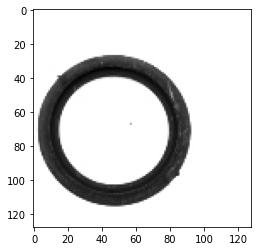

tensor([[-2.3842e-07, -1.5064e+01]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
tensor(0., device='cuda:0')


In [51]:
from PIL import Image
import matplotlib.pyplot as plt

image_num = 1795

IMM = img_test[image_num][0].to("cpu")
print(IMM.size())
plt.imshow(IMM,cmap='gray')
plt.show()

Out_Channels = 2
Dropout = 0.01
Convolution_Layer = [32, 0, 16, 16, 0, 16, 16, 0, 16, 16, 0, 16, 16, 0, 16, 16, 0]
Lineal_Layer = [16, 16]

model = VGG(
    Convolution_Layer,
    Lineal_Layer,
    Dropout,
    Out_Channels
    )

model.load_state_dict(torch.load(address + "/" +'0.9936655405405406% Drop[0.01] CL[32 0 16 16 0 16 16 0 16 16 0 16 16 0 16 16 0 ]LL[16 16 ].pth'))
model.eval()
model.to(device)


image = img_test[image_num].float().div_(255).unsqueeze_(1).to(device)

print(model.forward(image))
print(trg_test[image_num])


# Pizarra

In [ ]:
import torch
import copy
import torch.nn as nn
from collections import OrderedDict


# 128 VGG,B 1,D 0.001000,CL(64 0 16 16 0 16 16 0 16 16 0 16 16 0 ), LL(32 16 )0.994930%.pt
# pesa 203kb
# USO con imagenes de 128x128

DROP = 0.01

CV_BN_RELU0 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(1,64,3,1,1,1,1,0)),
          ('1', nn.BatchNorm2d(64)),
          ('2', nn.ReLU()),
          ('3', nn.Dropout(DROP))
        ]))

CV_BN_RELU1 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(64,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU2 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU3 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU4 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU5 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU6 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU7 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

CV_BN_RELU8 = nn.Sequential(OrderedDict([
          ('0', nn.Conv2d(16,16,3,1,1,1,1,0)),
          ('1', nn.Dropout(DROP)),
          ('2', nn.BatchNorm2d(16)),
          ('3', nn.ReLU())
        ]))

MAXPOOL0 = nn.AvgPool2d(2, 2)
MAXPOOL1 = nn.AvgPool2d(2, 2)
MAXPOOL2 = nn.AvgPool2d(2, 2)
MAXPOOL3 = nn.AvgPool2d(2, 2)
MAXPOOL4 = nn.AvgPool2d(2, 2)

FEATURES = nn.Sequential()

FEATURES.add_module('0', CV_BN_RELU0)
FEATURES.add_module('1', MAXPOOL0)
FEATURES.add_module('2', CV_BN_RELU1)
FEATURES.add_module('3', CV_BN_RELU2)
FEATURES.add_module('4', MAXPOOL1)
FEATURES.add_module('5', CV_BN_RELU3)
FEATURES.add_module('6', CV_BN_RELU4)
FEATURES.add_module('7', MAXPOOL2)
FEATURES.add_module('8', CV_BN_RELU5)
FEATURES.add_module('9', CV_BN_RELU6)
FEATURES.add_module('10',MAXPOOL3)
FEATURES.add_module('11',CV_BN_RELU7)
FEATURES.add_module('12',CV_BN_RELU8)
FEATURES.add_module('13',MAXPOOL4)

CLASSIFIER = nn.Sequential(OrderedDict([
          ('0', nn.Flatten()),
          ('1', nn.Linear(256,32)),
          ('2', nn.ReLU()),
          ('3', nn.Linear(32,16)),
          ('4', nn.ReLU()),
          ('5', nn.Linear(16,2)), # 2 = N_CLASES
        ]))

model =  nn.Sequential(OrderedDict([
            ('FEATURES', FEATURES),
            ('CLASSIFIER', CLASSIFIER),
            ('SOFTMAX', nn.LogSoftmax(1))
            ]))